# R-CNN with VGG16

In [1]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from IPython import display

import config
from config import Config
import util

from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.utils import plot_model
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from fast_ml.model_development import train_valid_test_split
#from sklearn.preprocessing import LabelBinarizer
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model
from numpy import save, load


In [2]:
"""
Setting Custom Configuration
"""

class WiderFaceConfig(Config):
    """Configuration for training on WIDER face dataset.
    WiderFaceConfig classs derives from the base Config class and overrides configurations specific
    to the WIDER Face dataset.
    """
    NAME = "wider_face_experiment1"
    WEIGHTS = "imagenet"
    LEARNING_RATE = 0.0001
    ROTATION_RANGE_IMAGEGEN = 90
    DTYPE_IMAGEGEN = 'uint8'
    MONITOR = 'val_loss'
    SAVE_FREQ = 'epoch'
    STEPS_PER_EPOCH = 10
    TOTAL_EPOCHS = 1000
    VALIDATION_STEPS = 2
    NUM_CLASSES = 2
    
config = WiderFaceConfig()    

In [3]:
config = WiderFaceConfig()

In [4]:
#setting image and annotation paths
#image_path = "WIDER FACE/WIDER_train/images"
#annot_path = "WIDER FACE/wider_face_split"

image_path = "../WIDER FACE/wider_train_final_950/train_set/images"
annot_path = "../WIDER FACE/wider_train_final_950/train_set/annots"

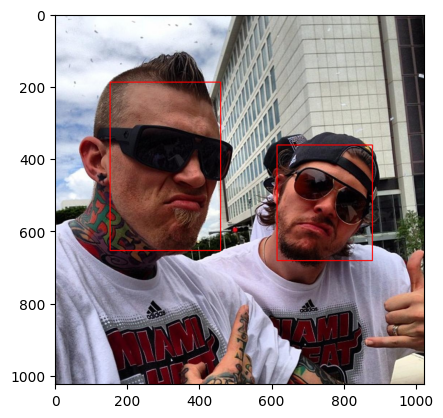

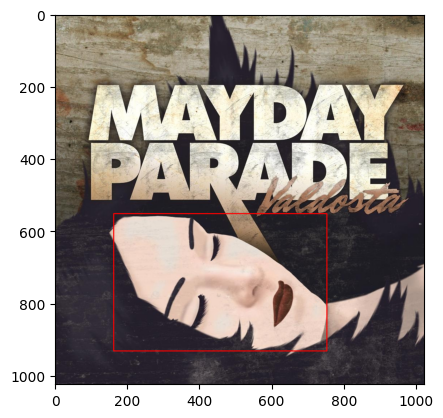

In [12]:
# draw rectangles on first image of the dataset using anotaions upto 9(<10)
for e,i in enumerate(os.listdir(annot_path)):
    if e < 2:
        filename = i.split(".")[0]+".jpg"
        #print(filename)
        img = cv2.imread(os.path.join(image_path,filename), cv2.IMREAD_ANYCOLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        df = pd.read_csv(os.path.join(annot_path,i), sep='\t', names=['temp'])
        #plt.imshow(img)
        for row in df.iterrows():
            x1 = int(row[1][0].split(" ")[0])
            y1 = int(row[1][0].split(" ")[1])
            x2 = int(row[1][0].split(" ")[2])
            y2 = int(row[1][0].split(" ")[3])
            cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), thickness = 2)
        plt.figure()
        plt.imshow(img)


In [6]:
def selective_search(image_path, image_name):
    """
    perform Fast Selective Search for the passed image
    """
    
    cv2.setUseOptimized(True)

    img = cv2.imread(os.path.join(image_path, image_name))

    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    ssresults = ss.process()
    
    return ssresults

# Image Preprocessing & Train-Test data preparation  

In [ ]:
# train_images=[]
# train_labels=[]

In [ ]:
# for e,i in enumerate(os.listdir(annot_path)):
#     try:
#         #if i.startswith("airplane"):
#             filename = i.split(".")[0]+".jpg"
#             print(e,filename)
#             # image = cv2.imread(os.path.join(image_path,filename))
#             df = pd.read_csv(os.path.join(annot_path,i), sep='\t', names=['temp'])
#             gtvalues=[] 
#             for row in df.iterrows():
#                 x1 = int(row[1][0].split(" ")[0])
#                 y1 = int(row[1][0].split(" ")[1])
#                 x2 = int(row[1][0].split(" ")[2])
#                 y2 = int(row[1][0].split(" ")[3])
#                  # appending groundtruth values
#                 gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
#             ssresults = selective_search(image_path, filename)
#             imout = image.copy()
#             counter = 0
#             falsecounter = 0
#             flag = 0
#             fflag = 0
#             bflag = 0
#             for e,result in enumerate(ssresults):#
#                 if e < config.MAX_REGIONS and flag == 0:
#                     for gtval in gtvalues:
#                         x,y,w,h = result
#                         iou = util.calculate_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
#                         if counter < 30:
#                             if iou > 0.70:
#                                 timage = imout[y:y+h,x:x+w]
#                                 resized = cv2.resize(timage, (config.IMAGE_MIN_DIM, config.IMAGE_MAX_DIM), interpolation = cv2.INTER_AREA)
#                                 train_images.append(resized)
#                                 train_labels.append(1)
#                                 counter += 1
#                         else :
#                             fflag =1
#                         if falsecounter <30:
#                             if iou < 0.3:
#                                 timage = imout[y:y+h,x:x+w]
#                                 resized = cv2.resize(timage, (config.IMAGE_MIN_DIM,config.IMAGE_MAX_DIM), interpolation = cv2.INTER_AREA)
#                                 train_images.append(resized)
#                                 train_labels.append(0)
#                                 falsecounter += 1
#                         else :
#                             bflag = 1
#                     if fflag == 1 and bflag == 1:
#                         print("inside")
#                         flag = 1
#     except Exception as e:
#         print(e)
#         print("error in "+filename)
#         continue

In [ ]:
# X_new = np.array(train_images)
# y_new = np.array(train_labels)

In [ ]:
# X_new.shape

In [ ]:
# save('X_new.npy', X_new)
# save('y_new.npy', y_new)

In [5]:
X_new = load('X_new_950.npy')
y_new = load('y_new_950.npy')

In [13]:
X_new.shape

(31978, 224, 224, 3)

In [17]:
y_new.shape

(31978,)

# Model Formation and Training

In [15]:
# transfer learning from VGG16 model with imagenet weights.
vggmodel = VGG16(weights=config.WEIGHTS , include_top=True)
vggmodel.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [16]:
#freezing the [Block 1, Block 2, Block 3, Block 4] = first 15(index 0 to 14) layers => 10 trainable layers
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False

In [17]:
vggmodel.layers[-5]
print(vggmodel.layers[-5])

In [18]:
block5_pool_output = vggmodel.layers[-5].output
print(block5_pool_output)

KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 512), dtype=tf.float32, name=None), name='block5_pool/MaxPool:0', description="created by layer 'block5_pool'")


In [19]:
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
# custom layers -Block6
block6_conv1 = Conv2D(filters=1024, kernel_size=(3, 3), activation='relu', padding='same', name='block6_conv1')(block5_pool_output)
block6_conv2 = Conv2D(filters=1024, kernel_size=(3, 3), activation='relu', padding='same', name='block6_conv2')(block6_conv1)
block6_conv3 = Conv2D(filters=1024, kernel_size=(3, 3), activation='relu', padding='same', name='block6_conv3')(block6_conv2)
block6_pool = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block6_pool')(block6_conv3)

In [20]:
#Add the fully-connected layers 
flatten = Flatten(name='flatten')(block6_pool)
hidden_fc1 = Dense(4096, activation='relu', name='fc1')(flatten)
hidden_fc2 = Dense(4096, activation='relu', name='fc2')(hidden_fc1)
predictions = Dense(2, activation='softmax', name='predictions')(hidden_fc2)

In [21]:
model_final = Model(inputs = vggmodel.input, 
                    outputs = predictions)

In [ ]:
#import visualkeras
#visualkeras.layered_view(model)
plot_model(model_final, to_file='model_6blocks_plot.png', show_shapes=True, show_layer_names=True)

In [22]:
opt = Adam(learning_rate=config.LEARNING_RATE)

In [23]:
model_final.compile(loss = keras.losses.categorical_crossentropy, 
                    optimizer = opt, 
                    metrics=["accuracy"])

In [ ]:
#from sklearn.preprocessing import LabelBinarizer

In [ ]:
#labelbinarizer = LabelBinarizer()
#make_encoded_results = labelbinarizer.fit_transform(y_new)

In [ ]:
#lenc = util.MyLabelBinarizer()
#Y =  lenc.fit_transform(y_new)

## Train-Test-Validation Split

In [7]:
#Train-Test-Validation Split
X_train, X_test , y_train, y_test = train_test_split(X_new, y_new, test_size=0.40)
#X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(X_new, target=Y, train_size=0.8, valid_size=0.1, test_size=0.1)

#X_train, X_rem, y_train, y_rem = train_test_split(X_new, Y, train_size=0.60)
#test_size = 0.5
#X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=test_size)

In [ ]:
#print(X_train.shape,y_train.shape,X_valid.shape,y_valid.shape,X_test.shape,y_test.shape)

In [ ]:
# trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=config.ROTATION_RANGE_IMAGEGEN, dtype=config.DTYPE_IMAGEGEN)
# train_data = trdata.flow(x=X_train, y=y_train)
# vldata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=config.ROTATION_RANGE_IMAGEGEN, dtype=config.DTYPE_IMAGEGEN)
# valid_data = vldata.flow(x=X_valid, y=y_valid)
#tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=config.ROTATION_RANGE_IMAGEGEN, dtype=config.DTYPE_IMAGEGEN)
#test_data = tsdata.flow(x=X_test, y=y_test)

In [14]:
print(X_test.shape)

(12792, 224, 224, 3)


In [15]:
print(y_test.shape)

(12792,)


In [8]:
labelbin_test = util.MyLabelBinarizer()
y_test = labelbin_test.fit_transform(y_test)

## k-Fold Cross Validation

In [26]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

# ===============Stratified K-Fold======================

skf = KFold(n_splits=3, shuffle=True)
skf.get_n_splits(X_train, y_train)
fold_var = 1

TRAIN_ACCURACY = []
TRAIN_LOSS = []
VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

for train_index, val_index in skf.split(X_train, y_train):
    print("---Starting K-fold validation Iteration - "+str(fold_var)+"---")
    
    X_train_fold, y_train_fold = np.take(X_train, train_index, 0), np.take(y_train, train_index, 0)    
    X_valid_fold, y_valid_fold = np.take(X_train, val_index, 0), np.take(y_train, val_index, 0) 
    
    #X_train, y_train = X_new.iloc[train_index], Y.iloc[train_index]
    #X_valid, y_valid = X_new.iloc[val_index], Y.iloc[val_index]
    
    labelbin = util.MyLabelBinarizer()
    y_train_fold_bin = labelbin.fit_transform(y_train_fold)
    y_valid_fold_bin =  labelbin.fit_transform(y_valid_fold)

    #initialize ImageDataGenerators 
    train_datagen = ImageDataGenerator(horizontal_flip=True, 
                                       vertical_flip=True, 
                                       rotation_range=config.ROTATION_RANGE_IMAGEGEN, 
                                       dtype=config.DTYPE_IMAGEGEN)
    
    validation_datagen = ImageDataGenerator(horizontal_flip=True, 
                                            vertical_flip=True, 
                                            rotation_range=config.ROTATION_RANGE_IMAGEGEN, 
                                            dtype=config.DTYPE_IMAGEGEN)
    
    train_data = train_datagen.flow(x=X_train_fold, y=y_train_fold_bin)
    
    valid_data = validation_datagen.flow(x=X_valid_fold, y=y_valid_fold_bin)
    
    model_name = "exp4_rcnn_vgg16_kfcv_"+str(fold_var)+".h5"
    checkpoint = ModelCheckpoint(model_name, monitor=config.MONITOR, verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=config.SAVE_FREQ)
    early = EarlyStopping(monitor=config.MONITOR, min_delta=config.MIN_DELTA, patience=config.PATIENCE, verbose=1, mode='auto')

    # fit model
    #history = model.fit(train_generator, epochs=epoch)
    history = model_final.fit(x= train_data, steps_per_epoch= config.STEPS_PER_EPOCH, epochs= config.TOTAL_EPOCHS, validation_data= valid_data, validation_steps=config.VALIDATION_STEPS, callbacks=[checkpoint,early])

    #score = model_final.evaluate(X_test, y_test, verbose=1)
    #predictions = model_final.predict(validation_generator, verbose=1)
    #y_predictions = np.argmax(predictions, axis=1)
    #true_classes = validation_generator.classes
    
    TRAIN_ACCURACY.append(history.history['accuracy'])
    TRAIN_LOSS.append(history.history['loss'])
    VALIDATION_ACCURACY.append(history.history['val_accuracy'])
    VALIDATION_LOSS.append(history.history['val_loss'])
    
    tf.keras.backend.clear_session()
    
    fold_var += 1
    
    # evaluate validation performance
    #print("***Performance on Validation data***")
    #val_acc, val_prec, val_fScore = my_metrics(true_classes, y_predictions)

---Starting K-fold validation Iteration - 1---
Epoch 1/1000
10/10 [==============================] - ETA: 0s - loss: 2.1496 - accuracy: 0.7406
Epoch 1: val_loss improved from inf to 0.49337, saving model to exp4_rcnn_vgg16_kfcv_1.h5
10/10 [==============================] - 18s 601ms/step - loss: 2.1496 - accuracy: 0.7406 - val_loss: 0.4934 - val_accuracy: 0.8438
Epoch 2/1000
10/10 [==============================] - ETA: 0s - loss: 0.2576 - accuracy: 0.8687
Epoch 2: val_loss improved from 0.49337 to 0.14997, saving model to exp4_rcnn_vgg16_kfcv_1.h5
10/10 [==============================] - 5s 517ms/step - loss: 0.2576 - accuracy: 0.8687 - val_loss: 0.1500 - val_accuracy: 0.9062
Epoch 3/1000
10/10 [==============================] - ETA: 0s - loss: 0.1226 - accuracy: 0.9031
Epoch 3: val_loss improved from 0.14997 to 0.14971, saving model to exp4_rcnn_vgg16_kfcv_1.h5
10/10 [==============================] - 5s 511ms/step - loss: 0.1226 - accuracy: 0.9031 - val_loss: 0.1497 - val_accuracy: 

In [27]:
save('train_acc.npy', np.array(TRAIN_ACCURACY))
save('train_loss.npy', np.array(TRAIN_LOSS))
save('val_acc.npy', np.array(VALIDATION_ACCURACY))
save('val_loss.npy', np.array(VALIDATION_LOSS))

In [17]:
TRAIN_ACCURACY = load('train_acc.npy', allow_pickle=True)
TRAIN_LOSS = load('train_loss.npy', allow_pickle=True)
VALIDATION_ACCURACY = load('val_acc.npy', allow_pickle=True)
VALIDATION_LOSS = load('val_loss.npy',allow_pickle=True)

In [18]:
print(VALIDATION_ACCURACY)

[list([0.84375, 0.90625, 0.875, 0.84375, 0.890625, 0.953125, 0.96875, 0.96875, 0.96875, 0.984375, 0.953125, 1.0, 1.0, 1.0, 0.96875, 0.953125, 0.921875, 0.9375, 0.96875, 0.984375, 0.984375, 0.984375, 0.96875, 0.921875, 0.984375, 1.0, 0.9375, 0.953125, 1.0, 0.953125, 1.0, 0.96875, 0.96875, 1.0, 0.984375, 0.921875, 0.96875, 1.0, 0.953125, 0.984375, 1.0, 0.96875, 0.984375, 0.9375, 0.984375, 0.96875, 0.984375, 0.96875, 0.96875, 1.0, 1.0, 1.0, 1.0, 0.984375, 0.984375, 1.0, 0.984375, 0.96875, 0.984375, 1.0, 1.0, 0.984375, 0.984375, 0.921875, 1.0, 0.984375, 0.96875, 0.96875, 0.96875, 0.984375, 0.984375, 1.0, 0.984375, 1.0, 0.984375, 1.0, 0.96875, 0.96875, 0.96875, 1.0, 0.984375, 1.0, 0.984375, 0.984375, 0.96875, 0.96875, 0.984375, 1.0, 0.96875, 1.0, 1.0, 0.984375, 0.984375, 0.9375, 1.0, 0.96875, 1.0, 0.953125, 0.984375, 0.953125, 0.96875, 0.984375, 1.0, 1.0, 1.0, 0.984375, 0.984375, 1.0, 1.0, 0.96875, 0.984375, 0.984375, 0.984375, 1.0, 0.96875, 1.0, 1.0, 0.953125, 0.984375, 0.984375, 0.96875, 

In [ ]:
# checkpoint = ModelCheckpoint("exp4_rcnn_vgg16_kfcv_1.h5", monitor=config.MONITOR, verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=config.SAVE_FREQ)
# early = EarlyStopping(monitor=config.MONITOR, min_delta=config.MIN_DELTA, patience=config.PATIENCE, verbose=1, mode='auto')

In [ ]:
#history = model_final.fit(x= train_data, steps_per_epoch= config.STEPS_PER_EPOCH, epochs= config.TOTAL_EPOCHS, validation_data= valid_data, validation_steps=config.VALIDATION_STEPS, callbacks=[checkpoint,early])

# Visualization of Training Results

In [9]:
from keras.models import load_model
model_final = load_model('exp4_rcnn_vgg16_kfcv_3.h5')


In [27]:
print(y_test.shape)

(12792, 2)


In [10]:
# Generate generalization metrics
score = model_final.evaluate(X_test, y_test, verbose=1)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

400/400 [==============================] - 91s 205ms/step - loss: 0.0320 - accuracy: 0.9944
Test loss: 0.031961407512426376 / Test accuracy: 0.9943714737892151


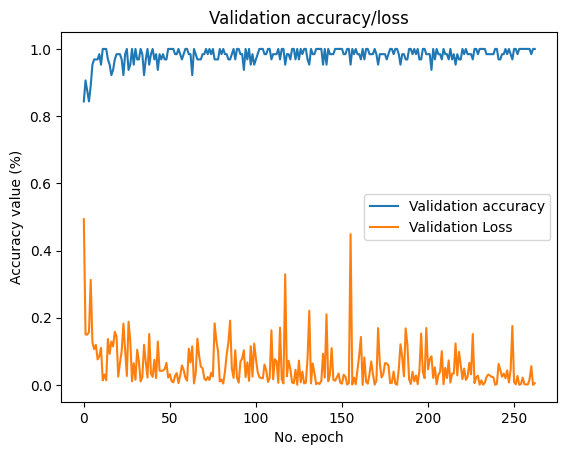

In [25]:
# Visualize history
# Plot history: Loss
# plt.plot(history.history['val_loss'])
# plt.title('Validation loss history')
# plt.ylabel('Loss value')
# plt.xlabel('No. epoch')
# plt.show()

# Plot history: Accuracy of first Iteration
plt.plot(VALIDATION_ACCURACY[0])
plt.plot(VALIDATION_LOSS[0])
plt.title('Validation accuracy/loss')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.legend(["Validation accuracy","Validation Loss"])
plt.show()

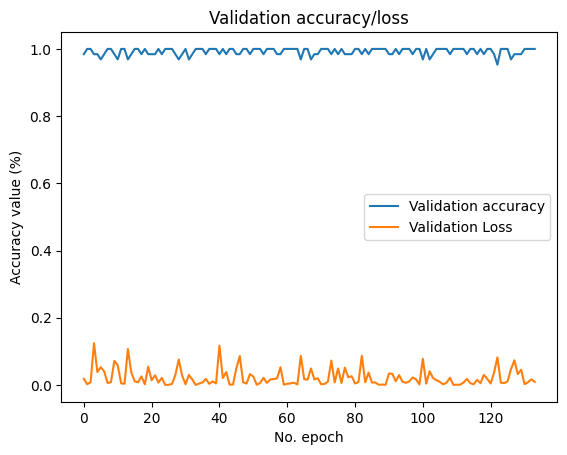

In [26]:
# Visualize history
# Plot history: Loss
# plt.plot(history.history['val_loss'])
# plt.title('Validation loss history')
# plt.ylabel('Loss value')
# plt.xlabel('No. epoch')
# plt.show()

# Plot history: Accuracy of second Iteration
plt.plot(VALIDATION_ACCURACY[1])
plt.plot(VALIDATION_LOSS[1])
plt.title('Validation accuracy/loss')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.legend(["Validation accuracy","Validation Loss"])
plt.show()

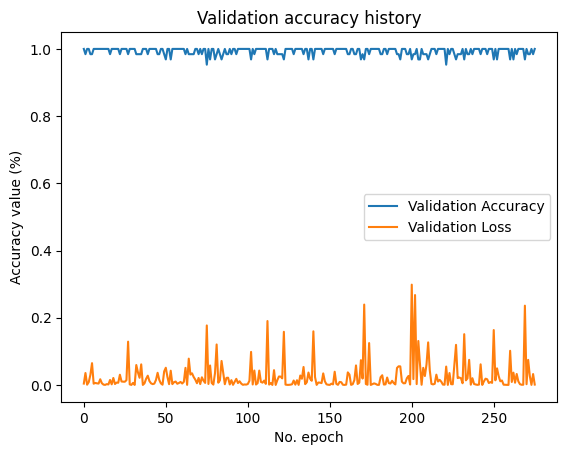

In [27]:
# Visualize history
# Plot history: Loss
# plt.plot(history.history['val_loss'])
# plt.title('Validation loss history')
# plt.ylabel('Loss value')
# plt.xlabel('No. epoch')
# plt.show()

# Plot history: Accuracy of thirs iteration
plt.plot(VALIDATION_ACCURACY[2])
plt.plot(VALIDATION_LOSS[2])
plt.title('Validation accuracy history')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.legend(["Validation Accuracy", "Validation Loss"])
plt.show()

In [ ]:
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train Loss","Validation Loss"])
plt.show()
#plt.savefig('chart loss.png')

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [ ]:
validation_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=config.ROTATION_RANGE_IMAGEGEN, dtype=config.DTYPE_IMAGEGEN)
test_data = validation_datagen.flow(x=X_test, y=y_test)

In [ ]:
# Generate generalization metrics
score = model_final.evaluate(X_test, y_test, verbose=1)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

# Prediction

In [ ]:
#model_final = load_model('exp4_rcnn_vgg16_1.h5')

1/1 [==============================] - 1s 1s/step
not face


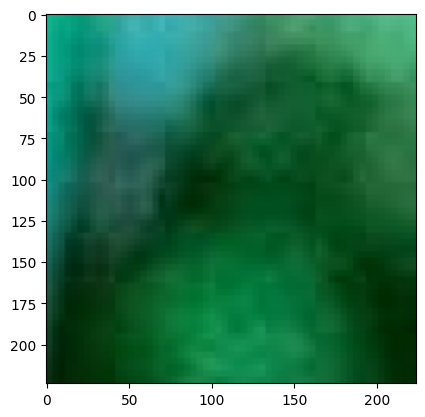

In [36]:
im = X_test[40]
plt.imshow(im)
img = np.expand_dims(im, axis=0)
out= model_final.predict(img)
if out[0][0] > out[0][1]:
    print("face")
else:
    print("not face")

1/1 [==============================] - 0s 26ms/step


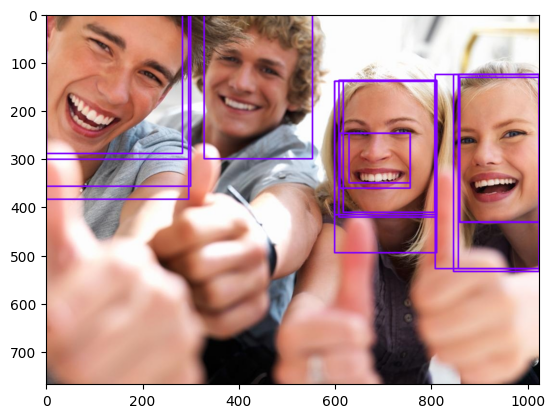

In [47]:
rects = []

filename = '232.jpg'
img = cv2.imread(os.path.join(image_path, filename))
ssresults = selective_search(image_path, filename)
imout = img.copy()
for e,result in enumerate(ssresults):
    if e < config.MAX_REGIONS:
        x,y,w,h = result
        timage = imout[y:y+h,x:x+w]
        resized = cv2.resize(timage, (config.IMAGE_MIN_DIM, config.IMAGE_MAX_DIM), interpolation = cv2.INTER_AREA)
        img = np.expand_dims(resized, axis=0)
        out= model_final.predict(img)
        if out[0][0] > 0.65:
            rects.append([x, y, x+w, y+h])
            cv2.rectangle(imout, (x, y), (x+w, y+h), (255, 0, 127), 2, cv2.LINE_AA)
plt.figure()
plt.imshow(cv2.cvtColor(imout, cv2.COLOR_BGR2RGB))

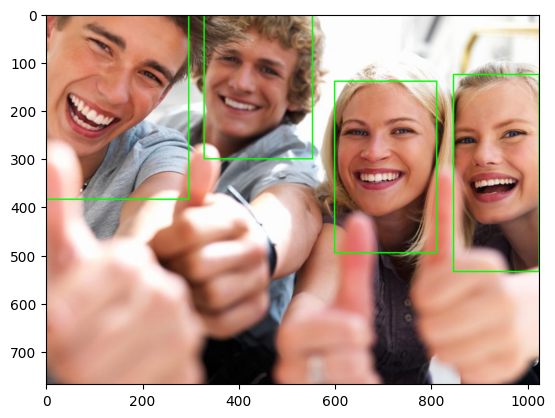

In [48]:
filename = '232.jpg'
img = cv2.imread(os.path.join(image_path, filename))
imout2 = img.copy()

rects_ = np.array(rects)
pick = util.non_max_suppression_fast(rects_, overlapThresh=0.40) #original = 0.65

# draw the final bounding boxes
for (xA, yA, xB, yB) in pick:
    cv2.rectangle(imout2, (xA, yA), (xB, yB), (0, 255, 0), 2)
    
plt.figure()
plt.imshow(cv2.cvtColor(imout2, cv2.COLOR_BGR2RGB))